In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import bootstrap
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from itertools import cycle
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression, LassoCV,LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve, auc,roc_auc_score


Q1. Time Series Classification Part 1: Feature Creation/Extraction

(a) Download the AReM data

In [2]:
subdir = []
path = os.getcwd()
path = os.path.join(path,'../data/AReM')

for folder in os.listdir(path):
    fullpath = os.path.join(path, folder)
    
    #remove bendingType.pdf and sensorsPlacement.pdf
    if folder.endswith('.pdf'): 
        pass
    else:
        subdir.append(fullpath)

(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,2, and 3 in other folders as test data and other datasets as train data.

In [3]:
train_file = []
test_file = []

for each_folder in subdir:
    
    if len(os.listdir(each_folder)) < 10: #only bending1 and bending2 have less than 10 folders
        for count, data in enumerate(os.listdir(each_folder)):
            if data in ['dataset1.csv', 'dataset2.csv']:
                test_file.append(os.path.join(each_folder,data))
            else:
                train_file.append(os.path.join(each_folder,data))
                
    else:
        for count, data in enumerate(os.listdir(each_folder)):
            if data in ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']:
                test_file.append(os.path.join(each_folder,data))
            else:
                train_file.append(os.path.join(each_folder,data))  


In [4]:
print(train_file[0])

/Users/myy/Desktop/DSCI552_HW4/notebook/../data/AReM/bending1/dataset7.csv


(c) Feature Extraction

i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

In [5]:
data_path_list =[]

for each_folder in subdir:
    for file in os.listdir(each_folder):
        path = os.path.join(each_folder, file)
        newPath = path.replace(os.sep, '/')
        data_path_list.append(newPath)
        
# Merging all data
Alldata = pd.DataFrame() 
for dataset in data_path_list:
    df = pd.read_csv(dataset, header=4, usecols=[*range(1, 7)])
    Alldata = pd.concat([Alldata, df],ignore_index=True)


ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [6]:
col_list = []
def header(col_names):
    for i in range(1, 7):
        for label in col_names:
            col_list.append(label + str(i))
    return col_list

col_headers = header(['min', 'max', 'mean', 'median', 'std_dev', '1st_quart', '3rd_quart'])

def features(file, split_time_series=None, multi_class = None):
    instance_list = []
    if 'bending' in file:
        class_type = 1
    else:
        class_type = 0
        
    df = pd.read_csv(file, header=4, usecols=[*range(1, 7)])
    dflist = list(df)
    if split_time_series is not None:
        dflist = np.array_split(df, split_time_series)
    for df in dflist:
        row = []
        stat_df = df.agg(['min', 'max', 'mean', 'median', 'std'])
        stat_df = stat_df.append(df.quantile(q=0.25))
        stat_df = stat_df.append(df.quantile(q=0.75))
        for col in [stat_df[f] for f in stat_df]:
            for data in col:
                row.append(data)
        row.append(class_type)
        instance_list.append(row)
    return instance_list

col_headers.append('class')

def instance_frame(file_list,split_size=None):
    df_total_instance = pd.DataFrame()
    total_instance_list = []
    for file in file_list:
        instance_features = features(file,split_size)
        total_instance_list = total_instance_list + instance_features

    df_total_instance = pd.DataFrame(total_instance_list, columns=col_headers)
    return df_total_instance

In [7]:
time_domain_data = instance_frame(data_path_list, 1)
print(time_domain_data)

     min1   max1      mean1  median1  std_dev1  1st_quart1  3rd_quart1  min2  \
0   36.25  48.00  43.969125    44.50  1.618364     43.3100       44.67   0.0   
1   37.00  48.00  43.454958    43.25  1.386098     42.5000       45.00   0.0   
2   33.00  47.75  42.179813    43.50  3.670666     39.1500       45.00   0.0   
3   33.00  45.75  41.678063    41.75  2.243490     41.3300       42.75   0.0   
4   37.25  45.00  40.624792    40.50  1.476967     39.2500       42.00   0.0   
..    ...    ...        ...      ...       ...         ...         ...   ...   
83  18.50  44.25  35.752354    36.00  4.614802     33.0000       39.33   0.0   
84  24.25  45.00  37.177042    36.25  3.581301     34.5000       40.25   0.0   
85  23.33  43.50  36.244083    36.75  3.822016     33.4575       39.25   0.0   
86  26.25  44.25  36.957458    36.29  3.434863     34.5000       40.25   0.0   
87  27.75  44.67  37.144833    36.33  3.758904     34.0000       40.50   0.0   

     max2     mean2  ...  1st_quart5  3

iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature

In [8]:
table_data = []
stats = time_domain_data[col_headers].describe()
stds = stats[2:3].values[0].tolist()
table_headers = ['Feature','Standard Deviation']

for i in range(0, len(col_headers)):
    row = []
    row.append(col_headers[i])
    row.append(stds[i])
    table_data.append(row)

df_std = pd.DataFrame(table_data, columns = table_headers)

In [9]:
bs_list = []
for i in range(0, len(col_headers)):
    arr = np.array(time_domain_data[col_headers[i]].astype(np.float64))
    bootstrap_ci = bootstrap((arr,), np.std, confidence_level=0.90,random_state=1, method='percentile')
    bs_list.append(bootstrap_ci.confidence_interval)
df_std['Confidence Interval'] = bs_list

In [10]:
df_std

,Feature,Standard Deviation,Confidence Interval
0,min1,9.569975,"(8.21734809687677, 10.704231108027612)"
1,max1,4.394362,"(3.306005074433925, 5.269063422099606)"
2,mean1,5.335718,"(4.675214277705429, 5.837115077961118)"
3,median1,5.440054,"(4.760293781687243, 5.964648674780459)"
4,std_dev1,1.772153,"(1.562763357753544, 1.9355695999646685)"
5,1st_quart1,6.153590,"(5.5423116547107885, 6.603819063160113)"
6,3rd_quart1,5.138925,"(4.308947238191441, 5.806971606808484)"
7,min2,0.000000,"(0.0, 0.0)"
8,max2,5.062729,"(4.595134343103269, 5.377385271413594)"
9,mean2,1.574164,"(1.3930997015043582, 1.698067629533194)"


iv. Use your judgement to select the three most important time-domain features.

Mean, Median, and Standard Deviation as time-domain features are good indicators of the pattern. 
After research, I am taking Mean, Standard Deviation and Third Quartile as the most important time-domain features.


Time Series Classification Part 2: Binary and Multiclass Classification

a. Binary Classification Using Logistic Regression

i. Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. 

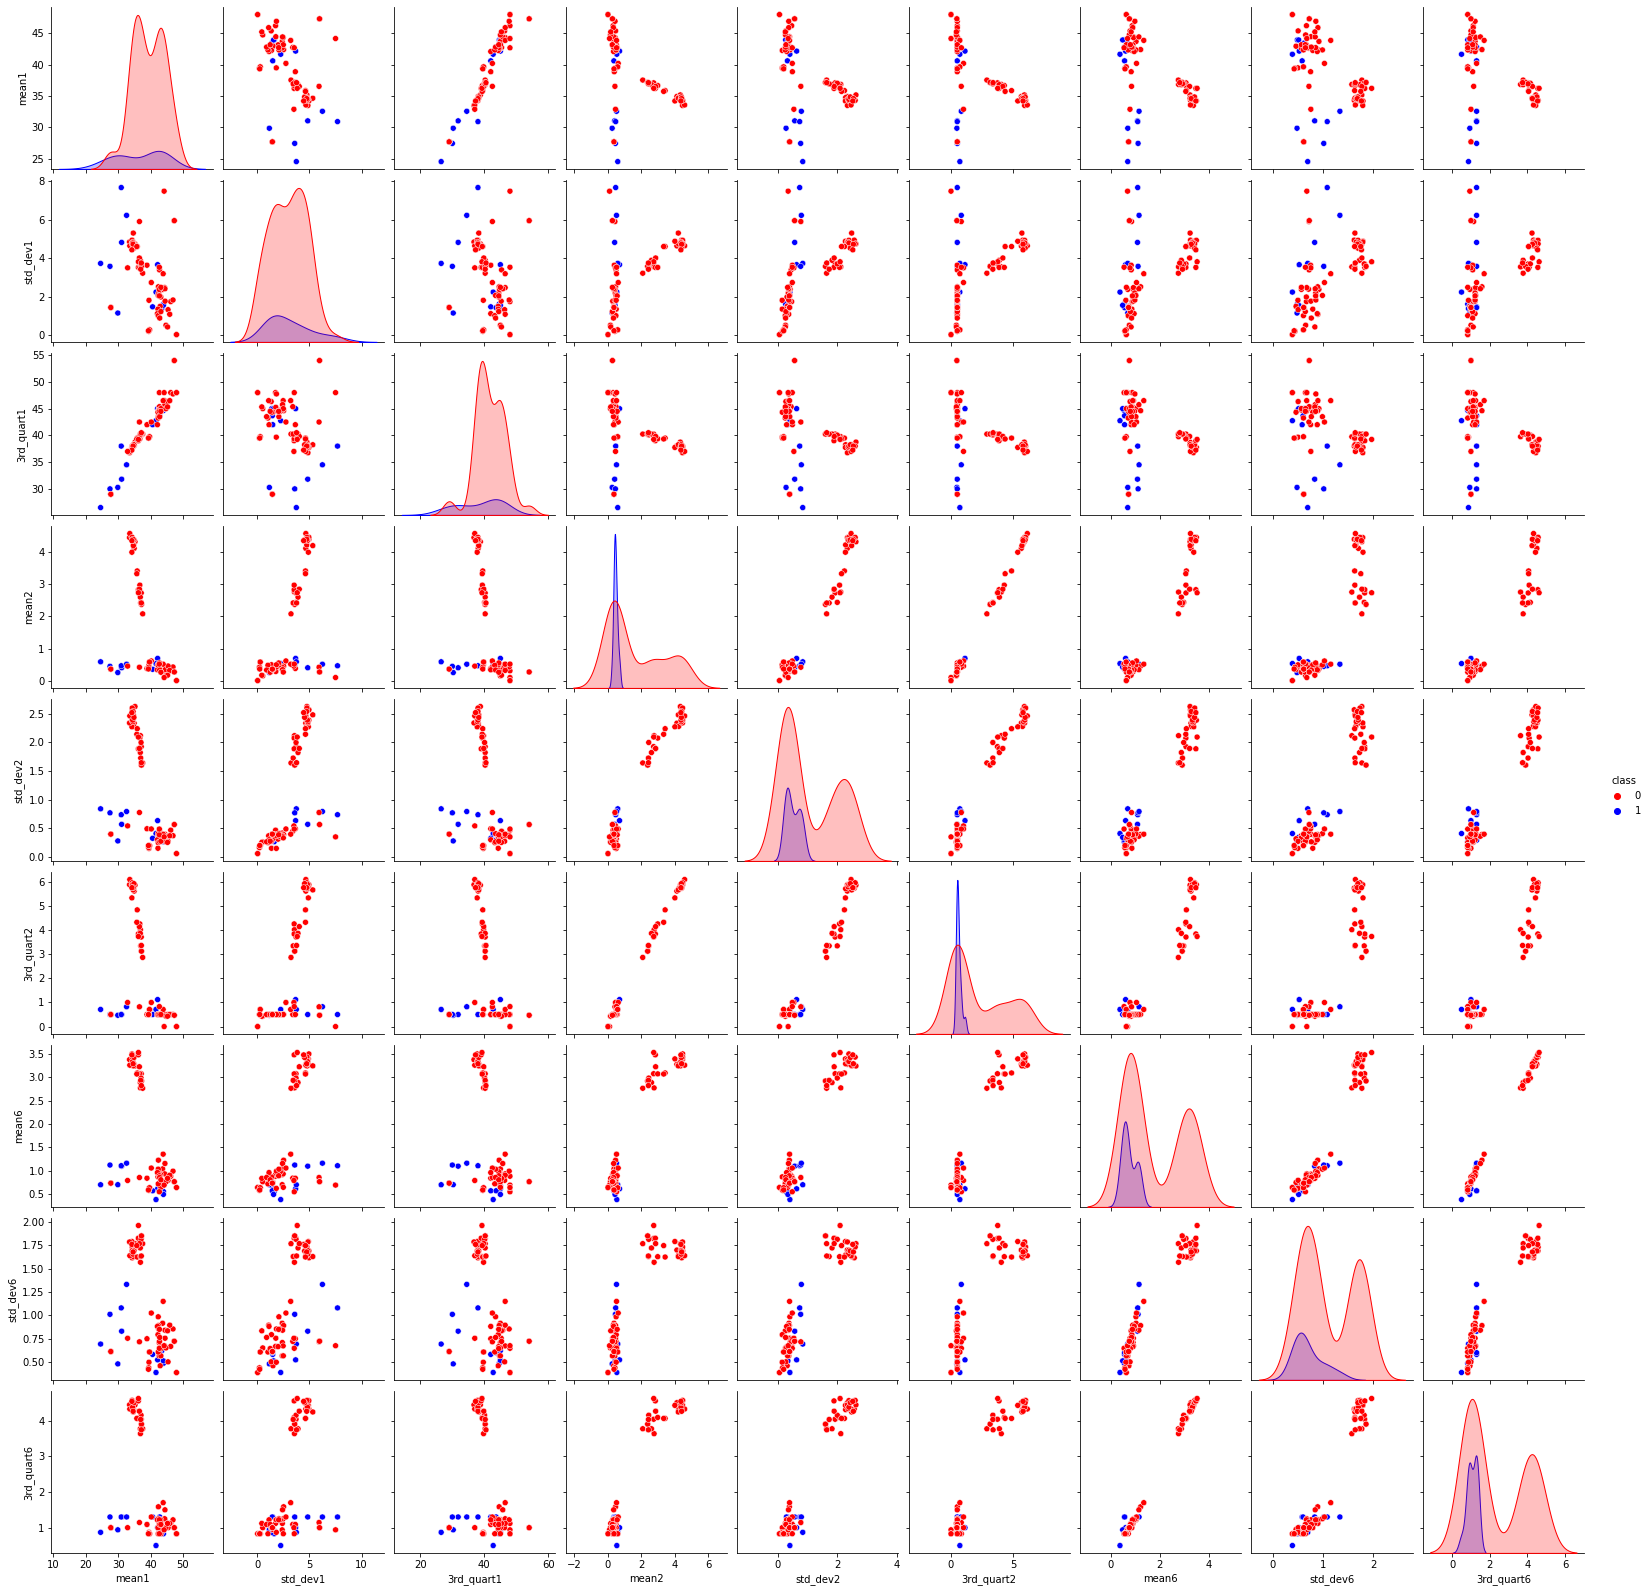

<Figure size 432x288 with 0 Axes>

In [11]:
time_domain_data = instance_frame(data_path_list, 1)

scatter_plot = sns.pairplot(data=time_domain_data, 
                            vars= ['mean1','std_dev1','3rd_quart1','mean2','std_dev2','3rd_quart2','mean6','std_dev6','3rd_quart6'],
                            kind='scatter',
                            palette= ['red','blue'],
                            hue='class')
plt.show()
plt.clf()

ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

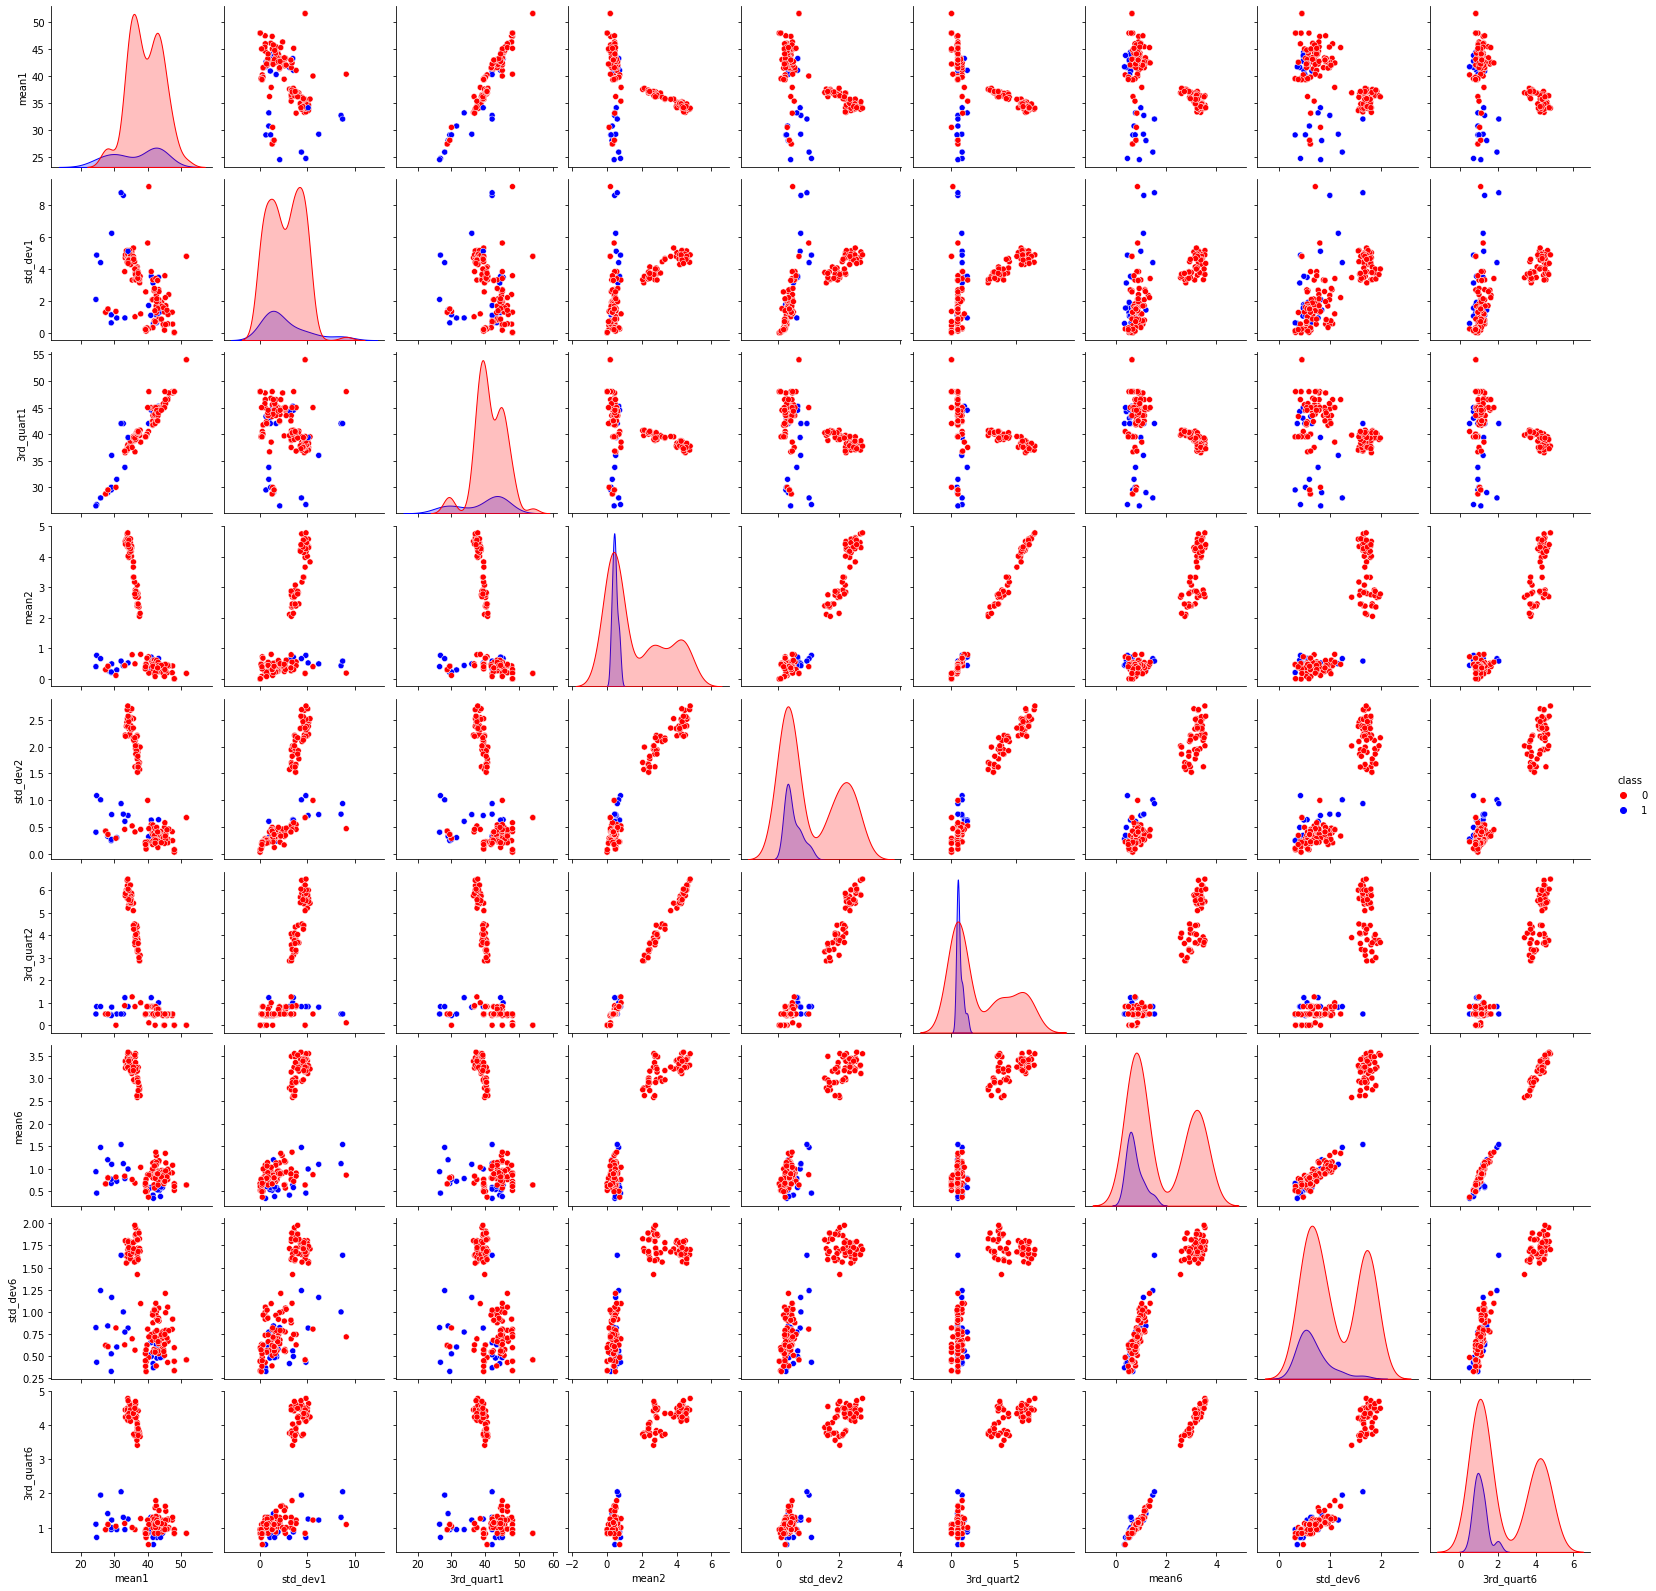

<Figure size 432x288 with 0 Axes>

In [12]:
split_time_domain_data = instance_frame(data_path_list,2)

scatter_plot = sns.pairplot(data=split_time_domain_data, 
                            vars=['mean1','std_dev1','3rd_quart1','mean2','std_dev2','3rd_quart2','mean6','std_dev6','3rd_quart6'],
                            kind='scatter', 
                            palette=['red','blue'],
                            hue='class')
plt.show()
plt.clf()

iii.Break each time series in your training set into
l∈ {1,2, . . . ,20} time series of approximately equal length and use logistic regression 5 to solve the binary classification problem, using time-domain features.

Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.

In [13]:
best_cv = 0
best_lvalue = 0
column_featured = np.delete(col_headers, 42)

for l in range(1,10):
    train_df = pd.DataFrame()
    y_train = []
    x_train = pd.DataFrame()
    
    train_df = instance_frame(train_file, l)
    y_train = train_df['class']
    x_train = train_df.drop(['class'], axis = 1)
    log_reg = LogisticRegression()
    
    for i in range(1,len(x_train.columns)):
        RFE_res = RFE(estimator=log_reg, n_features_to_select= i)
        RFE_res.fit(x_train,y_train)
        cv = cross_val_score(RFE_res,x_train,y_train,cv=5,scoring='accuracy')  
        mean =  np.mean(cv)
        
        if mean > best_cv:
            best_lvalue = l
            best_cv = mean
            best_no_feature = i   
            best_feature = column_featured[RFE_res.support_]


In [14]:
print("The best value of L for Logistic Regression is :" , best_lvalue )            
print("Optimal cv score for Logistic Regression is :" , best_cv)
print("Optimal number of features for Logistic Regression is : " , best_no_feature)
print("The Optimal features for Logistic Regression are : ", best_feature)

The best value of L for Logistic Regression is : 1
Optimal cv score for Logistic Regression is : 0.9714285714285715
Optimal number of features for Logistic Regression is :  12
The Optimal features for Logistic Regression are :  ['mean1' '3rd_quart1' 'max2' '3rd_quart2' 'median3' '1st_quart3' 'min5'
 'max5' 'mean5' 'median5' '1st_quart5' '3rd_quart6']


iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression β i’s as well as the p-values associated with them.

The Confusion Matrix is :
[[60  0]
 [ 0  9]]
The Accuracy is : 1.000000


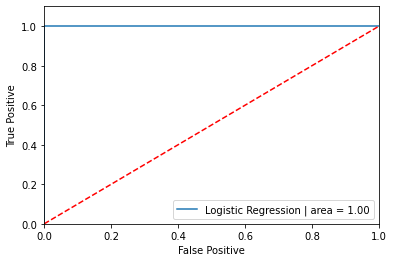

         Current function value: 0.000000
         Iterations: 21


In [15]:
train_df = instance_frame(train_file, best_lvalue)
y_train = train_df['class']
x_train = train_df.drop(['class'], axis=1)
x_train = x_train[best_feature]

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_train)

cm = confusion_matrix(y_train, y_pred)
print("The Confusion Matrix is :")
print(cm)

print("The Accuracy is : %f" %metrics.accuracy_score(y_train, y_pred))

ROC_AUC = roc_auc_score(y_train, y_pred)
fp, tp, threshold = roc_curve(y_train, y_pred)

plt.figure()
plt.plot(fp,tp,label='Logistic Regression | area = %0.2f'%ROC_AUC)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit(maxiter = 21)


In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       57
Method:                           MLE   Df Model:                           11
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        16:24:01   Log-Likelihood:            -6.8260e-08
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.496e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mean1         -4.4500   5804.486     -0.001      0.999   -1.14e+04    1.14e+04
3rd_quart1     1.5362   5927.009      0.000      1.000   -1.16e+04    1.16e+04
max2          -1.4671   2684.179     -0.001      1.000   -5262.360    5259.426
3rd_quart2     4.5122   1.51e+04      0.000      1.000   -2.96e+04    2.96e+04
median3       -4.1251      1e+04     -0.000      1.000   -1.96e+04    1.96e+04
1st_quart3     3.1086   9735.564      0.000      1.000   -1.91e+04    1.91e+04
min5           2.7874   3917.038      0.001      0.999   -7674.467    7680.042
max5           2.5557   3129.285      0.001      0.999   -6130.730    6135.841
mean5          5.8975   1.51e+04      0.000      1.000   -2.95e+04    2.95e+04
median5       -2.4178   2.42e+04     -0.000      1.000   -4.74e+04    4.73e+04
1st_quart5    -0.6193   1.45e+04  -4.28e-05      1.000   -2.83e+04    2.83e+04
3rd_quart6    -9.2316   1.95e+04     -0.000      1.000   -3.83e+04    3.82e+04
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

=> Coef: Beta and P>|z|: p-values

Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously.

The Confusion Matrix is :
[[15  0]
 [ 0  4]]
The Test Accuracy is : 1


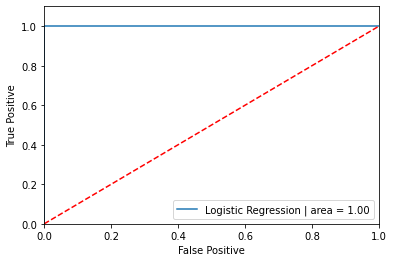

In [17]:
test_df = instance_frame(test_file, best_lvalue)
y_test = test_df['class']
x_test = test_df.drop(['class'], axis=1)
x_test = x_test[best_feature]

log_reg = LogisticRegression()
log_reg.fit(x_test, y_test)
y_pred = log_reg.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix is :")
print(cm)

print("The Test Accuracy is : %d" %metrics.accuracy_score(y_test,y_pred))    

ROU_AUC = roc_auc_score(y_test, y_pred)
fp, tp, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fp,tp,label='Logistic Regression | area = %0.2f'%ROU_AUC)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes. Classes are well-separated => unstable beta and p-values calculation

vii. From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

In [18]:
column_featured = np.delete(col_headers, 42)
best_cv = 0
best_lvalue = 0

for l in range(1,21):
    y_train = []
    x_train = pd.DataFrame()
    train_df = pd.DataFrame()
    
    train_df = instance_frame(train_file,l)
    y_train = train_df['class']
    x_train = train_df.drop(['class'], axis=1)
    
    ran = RandomUnderSampler()
    x_sampled_train, y_sampled_train = ran.fit_resample(x_train,y_train)
    log_reg = LogisticRegression()   
    
    for i in range(1,len(x_train.columns)):
        RFE_res = RFE(estimator=log_reg, n_features_to_select= i)
        RFE_res.fit(x_sampled_train, y_sampled_train)
        cv = cross_val_score(RFE_res, x_sampled_train, y_sampled_train, cv=5, scoring='accuracy')  
        mean  =  np.mean(cv)
        
        if mean > best_cv:
            best_lvalue = l
            best_cv = mean
            best_no_feature = i   
            best_feature = column_featured[RFE_res.support_]


In [19]:
print("The best value of L for case control sampling is :" , best_lvalue )            
print("Optimal CV score for case control sampling is :" , best_cv)
print("Optimal number of features for case control sampling : " , best_no_feature)
print("The Optimal features for for case control sampling are : ", best_feature)

The best value of L for case control sampling is : 5
Optimal CV score for case control sampling is : 0.9333333333333333
Optimal number of features for case control sampling :  39
The Optimal features for for case control sampling are :  ['min1' 'max1' 'mean1' 'median1' 'std_dev1' '1st_quart1' '3rd_quart1'
 'min2' 'max2' 'mean2' 'median2' 'std_dev2' '1st_quart2' '3rd_quart2'
 'min3' 'max3' 'mean3' 'median3' 'std_dev3' '1st_quart3' '3rd_quart3'
 'max4' 'mean4' 'median4' 'std_dev4' '1st_quart4' '3rd_quart4' 'min5'
 'max5' 'mean5' 'median5' 'std_dev5' '1st_quart5' '3rd_quart5' 'max6'
 'mean6' 'median6' 'std_dev6' '1st_quart6']


The Confusion Matrix is :
[[45  0]
 [ 0 45]]
The AUC Score is : 1.000000


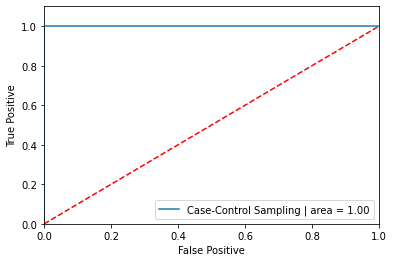

In [20]:
train_df = instance_frame(train_file, best_lvalue)
y_train = train_df['class']
x_train = train_df.drop(['class'], axis=1)
x_train = x_train[best_feature]
x_sampled_train, y_sampled_train =  RandomUnderSampler().fit_resample(x_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(x_sampled_train, y_sampled_train)
y_pred = log_reg.predict(x_sampled_train)

cm = confusion_matrix(y_sampled_train, y_pred)
print("The Confusion Matrix is :")
print(cm)

print("The AUC Score is : %f" %metrics.roc_auc_score(y_sampled_train, y_pred))

ROC_AUC = roc_auc_score(y_sampled_train, y_pred)
fp,tp,thresholds = roc_curve(y_sampled_train, y_pred)

plt.figure()
plt.plot(fp, tp, label='Case-Control Sampling | area = %0.2f' % ROC_AUC)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

The Confusion Matrix is :
[[20  0]
 [ 0 20]]
The AUC Score is : 1.000000


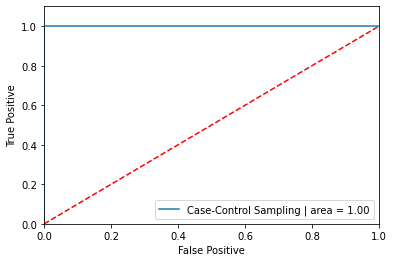

In [21]:
test_df = instance_frame(test_file, best_lvalue)
y_test = test_df['class']
x_test = test_df.drop(['class'], axis=1)
x_test = x_test[best_feature]
x_sampled_test, y_sampled_test = RandomUnderSampler().fit_resample(x_test, y_test)

log_reg = LogisticRegression()
log_reg.fit(x_sampled_test, y_sampled_test)
y_pred = log_reg.predict(x_sampled_test)

cm = confusion_matrix(y_sampled_test, y_pred)
print("The Confusion Matrix is :")
print(cm)

print("The AUC Score is : %f" %metrics.roc_auc_score(y_sampled_test, y_pred))

ROC_AUC = roc_auc_score(y_sampled_test, y_pred)
fp, tp, thresholds = roc_curve(y_sampled_test, y_pred)

plt.figure()
plt.plot(fp, tp, label='Case-Control Sampling | area = %0.2f' % ROC_AUC)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()


Binary Classification Using L 1 -penalized logistic regression

(i) Repeat 1(d)iii using L 1 -penalized logistic regression, 8 i.e. instead of using p-values for variable selection, use L 1 regularization. Note that in this problem,you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L 1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [22]:
best_lvalue = 0
best_cvalue = 0
best_cv = 0 

for l in range(1,21):
    y_train = []
    x_train = pd.DataFrame()
    train_df = pd.DataFrame()
    
    train_df = instance_frame(train_file, l)
    y_train = train_df['class']
    x_train = train_df.drop(['class'], axis=1)
    
    scalar = StandardScaler()
    x_train  = scalar.fit_transform(x_train)
    
    lasso = LogisticRegressionCV(penalty='l1',cv=StratifiedKFold(5),solver='liblinear')
    lasso = lasso.fit(x_train, y_train)
    cv = cross_val_score(lasso, x_train, y_train, cv=StratifiedKFold(5), scoring='accuracy')  
    mean =  np.mean(cv)
    
    if mean > best_cv:
        best_lvalue = l
        best_cvalue = lasso.C_[0]
        best_cv = mean
        

In [23]:
print("The best L-value for binary Log Reg L1 Penalty is : ", best_lvalue )
print("The best C-value for binary Log Reg L1 Penalty : " ,best_cvalue )
print("Optimal CV score for binary Log Reg L1 Penalty: " ,  best_cv)

The best L-value for binary Log Reg L1 Penalty is :  1
The best C-value for binary Log Reg L1 Penalty :  0.3593813663804626
Optimal CV score for binary Log Reg L1 Penalty:  0.9571428571428571


The Confusion Matrix is :
[[60  0]
 [ 1  8]]


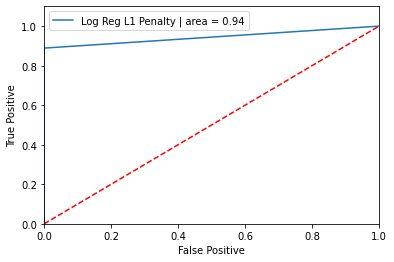

In [24]:
train_df = instance_frame(train_file, best_lvalue)
y_train = train_df['class']
x_train = train_df.drop(['class'], axis=1)

scalar = StandardScaler()
x_train  = scalar.fit_transform(x_train)
lasso = LogisticRegression(penalty = 'l1', C = best_cvalue, solver='liblinear')
lasso = lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_train)

cm = confusion_matrix(y_train, y_pred)
print("The Confusion Matrix is :")
print(cm)

ROC_AUC = roc_auc_score(y_train, y_pred)
fp, tp, thresholds = roc_curve(y_train, y_pred)

plt.figure()
plt.plot(fp, tp, label='Log Reg L1 Penalty | area = %0.2f' % ROC_AUC)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

The Confusion Matrix is :
[[15  0]
 [ 2  2]]
The Test Accuracy is : 0


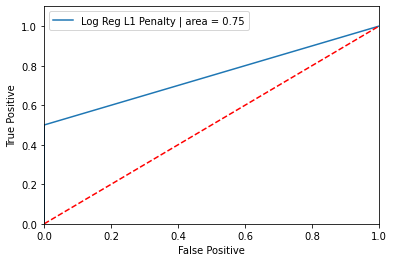

In [25]:
test_df = instance_frame(test_file, best_lvalue)
y_test = test_df['class']
x_test = test_df.drop(['class'], axis=1)

scalar = StandardScaler()
x_test  = scalar.fit_transform(x_test)
y_pred = lasso.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix is :")
print(cm)

print("The Test Accuracy is : %d" %metrics.accuracy_score(y_test,y_pred))    

ROC_AUC = roc_auc_score(y_test, y_pred)
fp, tp, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fp, tp, label='Log Reg L1 Penalty | area = %0.2f' % ROC_AUC)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

ii. Compare the L1 -penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

L-1 penalized regression model is easier to implement as it only needs one regularization parameter and avoids variable selection loop. The test accuracy for Logistic Regression with variable selection seems slightly better though.

Multi-class Classification

(i). Find the best l in the same way as you found it in 1(e)i to build an L 1 -penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [26]:
multi_class_labels = ['bending1', 'bending2','cycling', 'lying','sitting', 'standing', 'walking']

def get_features_multi_class(file, split_time_series=None):
    instance_list = []
    class_type = file.split('/')[-2]
    df = pd.read_csv(file, header=4, usecols=[*range(1, 7)])
    df_list = list(df)
    
    if split_time_series is not None:
        df_list = np.array_split(df, split_time_series)
    for df in df_list:
        row = []
        stat_df = df.agg(['min', 'max', 'mean', 'median', 'std'])
        stat_df = stat_df.append(df.quantile(q=0.25))
        stat_df = stat_df.append(df.quantile(q=0.75))
        
        for col in [stat_df[f] for f in stat_df]:
            for data in col:
                row.append(data)
        row.append(class_type)
        instance_list.append(row)
        
    return instance_list


In [27]:
def multi_class_instance_frame(file_list, split_size=None):
    total_instance_frame = pd.DataFrame()
    total_instance_list = []
    
    for file in file_list:
        instance_features = get_features_multi_class(file,split_size)
        total_instance_list = total_instance_list + instance_features

    total_instance_frame = pd.DataFrame(total_instance_list, columns=col_headers)
    
    return total_instance_frame

In [28]:
def multiclass_roc_curve(y_true, y_pred):
    lw=2
    fp = {}
    tp = {}
    ROC_AUC = {}
    colors = ['red','yellow','green','blue','purple','pink','gray']
    for i in range(0,7):
        fp, tp, _ = roc_curve(y_true[:, i], y_pred[:, i])
        ROC_AUC = auc(fp, tp)
        plt.plot(fp, tp, color=colors[i],lw=lw, label=f'ROC curve for {multi_class_labels[i]} (area = %0.2f)' %ROC_AUC)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [29]:
best_lvalue = 0
best_cv = 0

for l in range(1, 21):
    y_train = []
    x_train = pd.DataFrame()
    train_df = multi_class_instance_frame(train_file, l)
    y_train = train_df['class']
    x_train = train_df.drop(['class'], axis=1)

    scalar = StandardScaler()
    x_test = scalar.fit_transform(x_test)

    multi_lasso = LogisticRegressionCV(penalty='l1',multi_class='multinomial',cv=3,solver='saga')
    multi_lasso = multi_lasso.fit(x_train, y_train)
    cv = cross_val_score(multi_lasso, x_train, y_train, cv=3, scoring='accuracy')
    mean = np.mean(cv)
    
    if mean > best_cv:
        best_lvalue = l
        best_cv = mean
        best_cvalue = multi_lasso.C_[0]
        

In [30]:
print("The best L-value Multiclass Log Reg L1 penalty is : ", best_lvalue )
print("The best C-value Multiclass Log Reg L1 penalty is : " ,best_cvalue )
print("Optimal CV score Multiclass Log Reg L1 penalty is: " ,  best_cv)


The best L-value Multiclass Log Reg L1 penalty is :  1
The best C-value Multiclass Log Reg L1 penalty is :  10000.0
Optimal CV score Multiclass Log Reg L1 penalty is:  0.8405797101449276


The Confusion Matrix is :
[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]


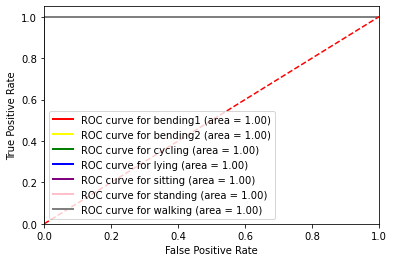

In [31]:
train_df = multi_class_instance_frame(train_file, best_lvalue)
y_train = train_df['class']
x_train = train_df.drop(['class'], axis=1)

scalar = StandardScaler()
x_train  = scalar.fit_transform(x_train)
multi_lasso = LogisticRegression(penalty = 'l1', C = best_cvalue, multi_class='multinomial', solver='saga')
multi_lasso = multi_lasso.fit(x_train, y_train)
y_pred = multi_lasso.predict(x_train)

cm = confusion_matrix(y_train, y_pred)
print("The Confusion Matrix is :")
print(cm)

y_train = label_binarize(y_train, classes = multi_class_labels)
y_pred = label_binarize(y_pred, classes = multi_class_labels)
multiclass_roc_curve(y_train, y_pred)


The Confusion Matrix is :
[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]
The Test Accuracy is : 0


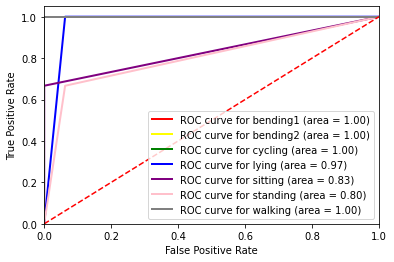

In [33]:
test_df = multi_class_instance_frame(test_file, best_lvalue)
y_test = test_df['class']
x_test = test_df.drop(['class'], axis=1)

scalar = StandardScaler()
x_test  = scalar.fit_transform(x_test)
y_pred = multi_lasso.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix is :")
print(cm)

print("The Test Accuracy is : %d" %metrics.accuracy_score(y_test,y_pred))    

y_test = label_binarize(y_test, classes= multi_class_labels)
y_pred = label_binarize(y_pred, classes= multi_class_labels)
multiclass_roc_curve(y_test, y_pred)


(ii) Repeat 1(f)i using a Naive Bayes’ classifier. Use both Gaussian and Multi-nomial priors and compare the results.


Naive Bayes' classifier, Gaussian priors

In [35]:
best_lvalue = 0
best_cv = 0

for l in range(1, 21):
    train_df = multi_class_instance_frame(train_file, l)
    y_train = train_df['class']
    x_train = train_df.drop(['class'], axis=1)
    
    nb_gaussian = GaussianNB()
    nb_gaussian = nb_gaussian.fit(x_train, y_train)
    cv = cross_val_score(nb_gaussian, x_train, y_train, cv=3, scoring='accuracy')
    mean = np.mean(cv)
    
    if mean > best_cv:
        best_lvalue = l
        best_cv = mean


In [36]:
print("The best L-value for multiclass naive bayes (Gaussian Prior) is : ", best_lvalue)
print("Optimal CV score for multiclass naive bayes (Gaussian Prior) is: ", best_cv)


The best L-value for multiclass naive bayes (Gaussian Prior) is :  2
Optimal CV score for multiclass naive bayes (Gaussian Prior) is:  0.782608695652174


The Confusion Matrix is :
[[10  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0]
 [ 0  0 24  0  0  0  0]
 [ 0  0  0 24  0  0  0]
 [ 0  2  0  0 20  2  0]
 [ 0  0  0  0  2 22  0]
 [ 0  0  0  0  0  0 24]]


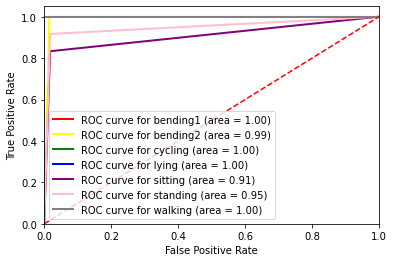

In [37]:
train_df = multi_class_instance_frame(train_file, best_lvalue)
y_train = train_df['class']
x_train = train_df.drop(['class'], axis=1)

nb_gaussian = GaussianNB()
nb_gaussian = nb_gaussian.fit(x_train, y_train)

y_pred = nb_gaussian.predict(x_train)
cm = confusion_matrix(y_train, y_pred)

print("The Confusion Matrix is :")
print(cm)

y_train = label_binarize(y_train, classes = multi_class_labels)
y_pred = label_binarize(y_pred, classes = multi_class_labels)
multiclass_roc_curve(y_train, y_pred)

The Confusion Matrix is :
[[4 0 0 0 0 0 0]
 [0 4 0 0 0 0 0]
 [0 0 6 0 0 0 0]
 [0 0 0 6 0 0 0]
 [0 0 0 1 4 1 0]
 [0 0 0 0 2 4 0]
 [0 0 0 0 0 0 6]]
The Test Accuracy is : 0


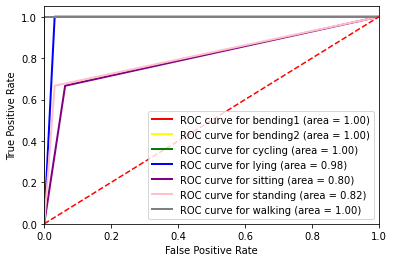

In [38]:
test_df = multi_class_instance_frame(test_file, best_lvalue)
y_test = test_df['class']
x_test = test_df.drop(['class'], axis=1)

y_pred = nb_gaussian.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix is :")
print(cm)

print("The Test Accuracy is : %d" %metrics.accuracy_score(y_test,y_pred))    

y_test = label_binarize(y_test, classes= multi_class_labels)
y_pred = label_binarize(y_pred, classes= multi_class_labels)
multiclass_roc_curve(y_test, y_pred)

Naive Bayes’ classifier, Multi-nomial priors

In [39]:
best_lvalue = 0
best_cv = 0 

for l in range(1,21):
    train_df = multi_class_instance_frame(train_file, l)
    y_train = train_df['class']
    x_train = train_df.drop(['class'], axis=1)
    
    nb_multinomial = MultinomialNB()
    nb_multinomial = nb_multinomial.fit(x_train, y_train)
    
    cv = cross_val_score(nb_multinomial, x_train, y_train, cv = 3, scoring='accuracy')  
    mean = np.mean(cv)
    
    if mean > best_cv:
        best_lvalue = l
        best_cv = mean

In [40]:
print("The best L-value for multiclass naive bayes (Multinomial Prior) is : ", best_lvalue )
print("Optimal CV score for multiclass naive bayes (Multinomial Prior) is: " ,  best_cv)

The best L-value for multiclass naive bayes (Multinomial Prior) is :  1
Optimal CV score for multiclass naive bayes (Multinomial Prior) is:  0.8405797101449276


The Confusion Matrix is :
[[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1 10  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]


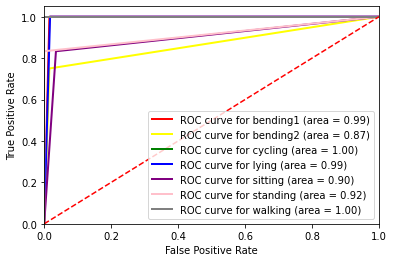

In [41]:
train_df = multi_class_instance_frame(train_file, best_lvalue)
y_train = train_df['class']
x_train = train_df.drop(['class'], axis=1)

nb_multinomial = MultinomialNB()
nb_multinomial = nb_multinomial.fit(x_train, y_train)
y_pred = nb_multinomial.predict(x_train)

cm = confusion_matrix(y_train, y_pred)
print("The Confusion Matrix is :")
print(cm)

y_train = label_binarize(y_train, classes= multi_class_labels)
y_pred = label_binarize(y_pred, classes= multi_class_labels)
multiclass_roc_curve(y_train, y_pred)

The Confusion Matrix is :
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
The Test Accuracy is : 0


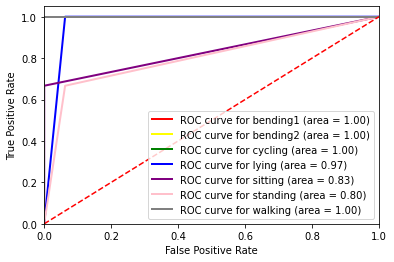

In [42]:
test_df = multi_class_instance_frame(test_file, best_lvalue)
y_test = test_df['class']
x_test = test_df.drop(['class'], axis=1)

y_pred = nb_multinomial.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

print("The Confusion Matrix is :")
print(cm)

print("The Test Accuracy is : %d" %metrics.accuracy_score(y_test,y_pred))    

y_test = label_binarize(y_test, classes= multi_class_labels)
y_pred = label_binarize(y_pred, classes= multi_class_labels)
multiclass_roc_curve(y_test, y_pred)

iii. Which method is better for multi-class classification in this problem?

Gaussian Naive Bayes Classifier is better for multi-clsas classification as AUC for most class is better compared to Multinomial Naive Bayes Classifier and Multiclass Logistic Regression. 